In [47]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


# **CARGA DE DATASET - TRAIN.CSV**

In [3]:
df_train= pd.read_excel('./Datathon-main/E-Commerce_train.xlsx')

In [4]:
df_train

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8994,8995,D,Ship,3,1,217,3,low,F,1,4177,1
8995,8996,F,Ship,5,3,232,3,medium,M,3,4526,0
8996,8997,A,Ship,4,5,260,3,medium,F,6,4221,0
8997,8998,B,Ship,4,2,184,3,medium,F,5,5931,1


*Revisando presencia de valores duplicados o nulos*

In [5]:
df_train[df_train.duplicated()] # No hay valores duplicados
df_train.isnull().sum()         # No hay valores nulos

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

# **Analisis Exploratorio**

*Correlacion entre las variables*

C:\Users\yoe_1\AppData\Local\Temp\ipykernel_1912\4279049525.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


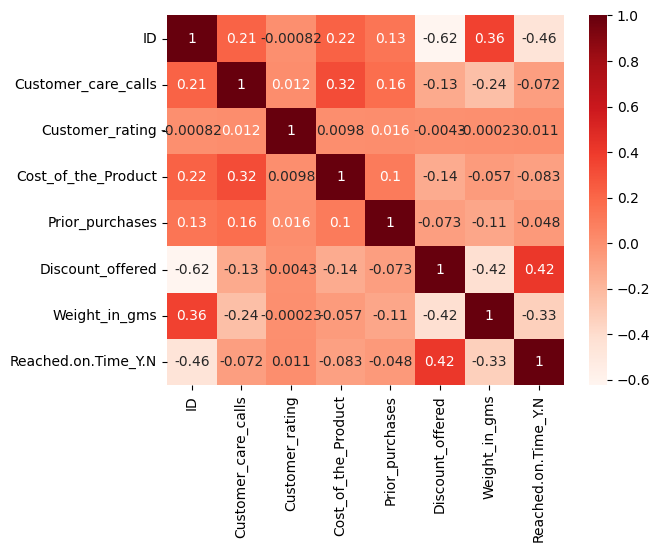

In [6]:
corr = df_train.corr()
sns.heatmap(corr, cmap="Reds", annot=True)
plt.show()

    Observaciones:
 *  Posible correlacion significativa entre las variables **Customer_care_calls** y **Cost_of_the_Product**

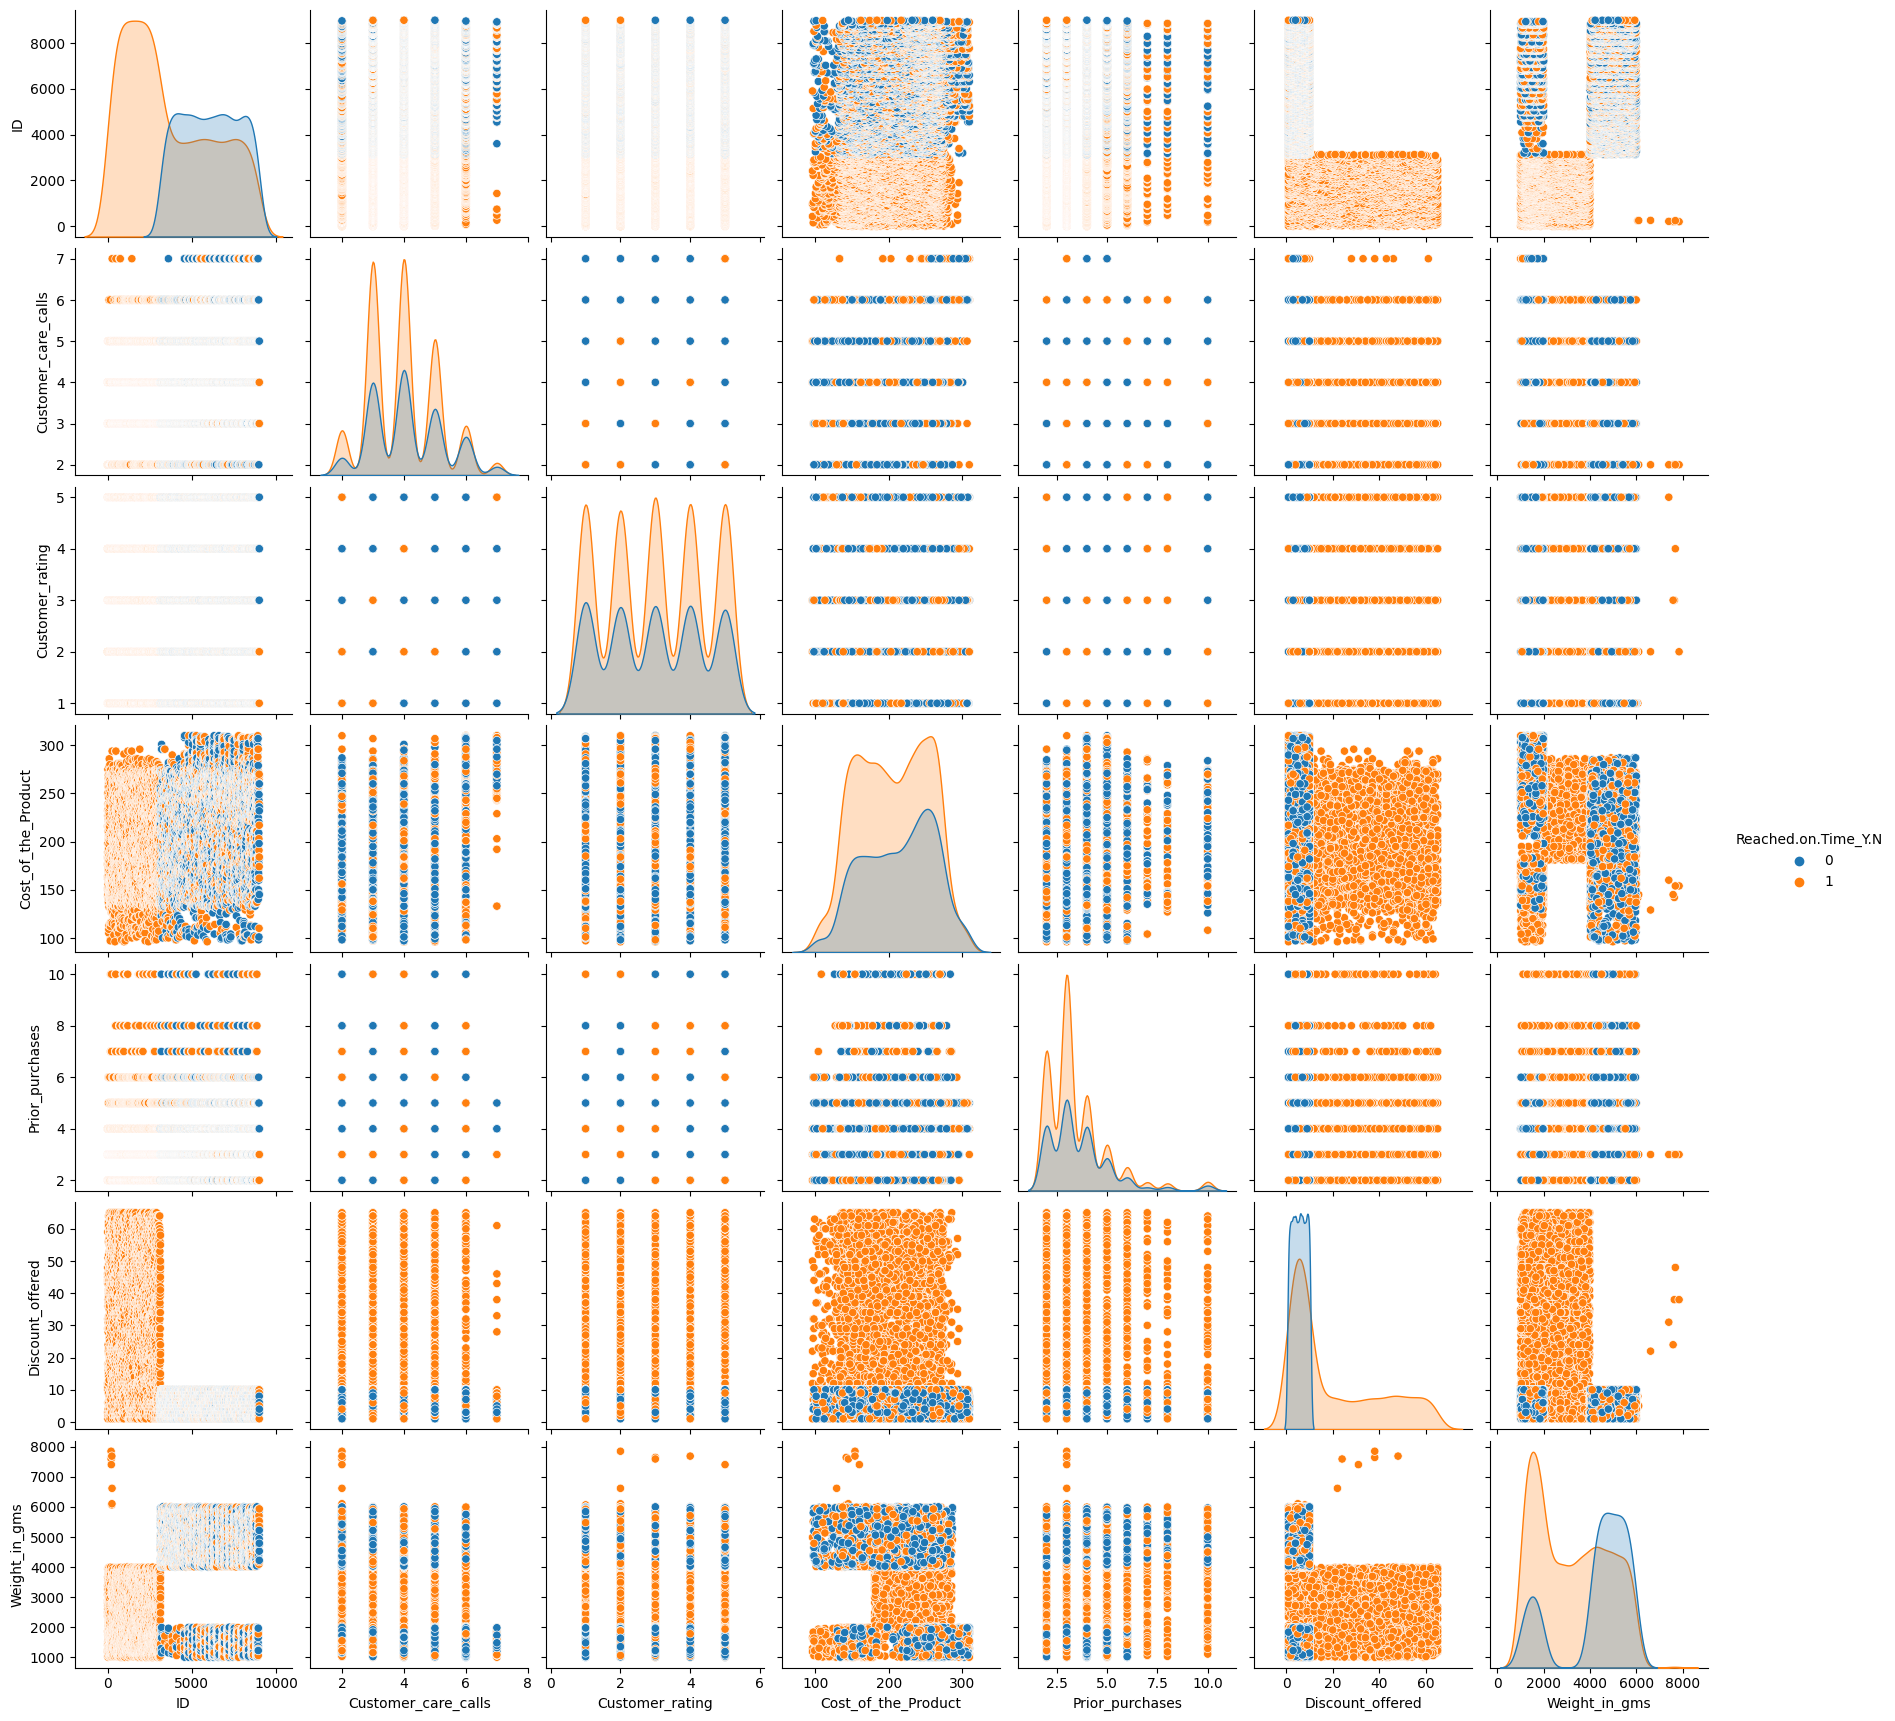

In [7]:
sns.pairplot(df_train,hue='Reached.on.Time_Y.N')

    Observacion:
*   **Paiplot** se utiliza para comprender el mejor conjunto de características para explicar una relación entre dos variables o para formar los grupos más separados. También ayuda a formar algunos modelos de clasificación simples dibujando algunas líneas simples o haciendo una separación lineal en nuestro conjunto de datos.

## **Analisis de las dimensiones**

Estas son las columnas relacionadas a las ordenes segun su tipo de información

| Categorica                  | Cuantitativa 	                 |
|-----------------------------|----------------------------------|
|Warehouse_block - nominal    | Customer_care_calls - discreta   |
|Mode_of_Shipment - nominal   | Cost_of_the_Product - discreta   |
|Customer_rating - ordinal    | Discount_offered - discreta      |
|Product_importance - ordinal | Weight_in_gms - discreta 	     |
|Gender - nominal             | Prior_purchases - discreta       |
|Reached.on.Time...- dicotoma |                                  |                               

### **Analizando variables cuantitativas**

In [8]:
df_train_cuant= df_train[['Customer_care_calls','Cost_of_the_Product','Discount_offered','Weight_in_gms','Prior_purchases']]

*Distribución de las variables cuantitativas*

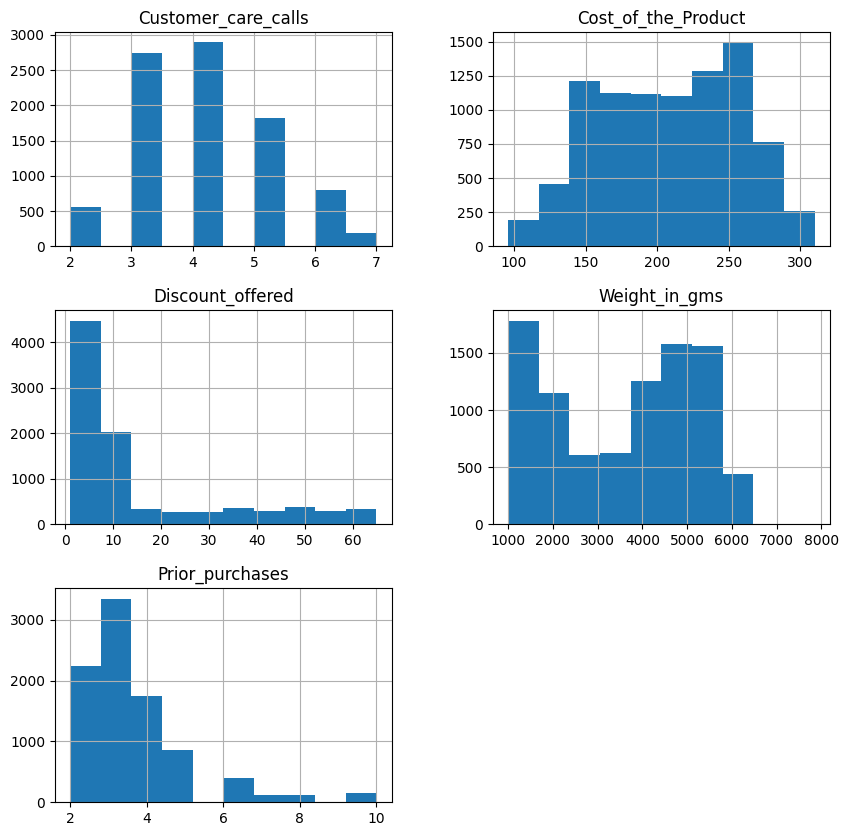

In [9]:
df_train_cuant.hist( column = ['Customer_care_calls','Cost_of_the_Product','Discount_offered','Weight_in_gms','Prior_purchases'], figsize=(10,10) )
plt.show()

    Observaciones
* Posiblemente **'Discount_offered'** tenga presencia de Outliers.
* Posiblemente **'prior purchase'** tenga presencia de Outliers.

*Identificando valores atipicos*

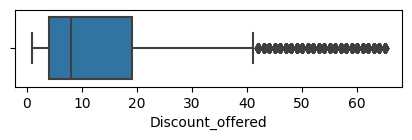

Cantidad de registros totales = 8999
Cantidad de outliers = 1193
Porcentaje de outliers = 13.257028558728749


In [10]:
# Box-Plot
Variable='Discount_offered'
data=df_train_cuant

Q1 = data[Variable].quantile(0.25)
Q3 = data[Variable].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

plt.figure(figsize = (5,1))
sns.boxplot(x = 'Discount_offered', data = df_train)
plt.show()

print('Cantidad de registros totales =', data.shape[0])
print('Cantidad de outliers =', data[(data[Variable]<BI) | (data[Variable]>BS)].shape[0] )
print('Porcentaje de outliers =', (data[(data[Variable]<BI) | (data[Variable]>BS)].shape[0]/data.shape[0]*100) )

    Observaciones
*  Los outliers representan mas del 10% de los datos por lo que sera conveniente corregirlo.

**Corrigiendo valores atipicos mediante Winsorizacion a la variable 'Discount_offered'**

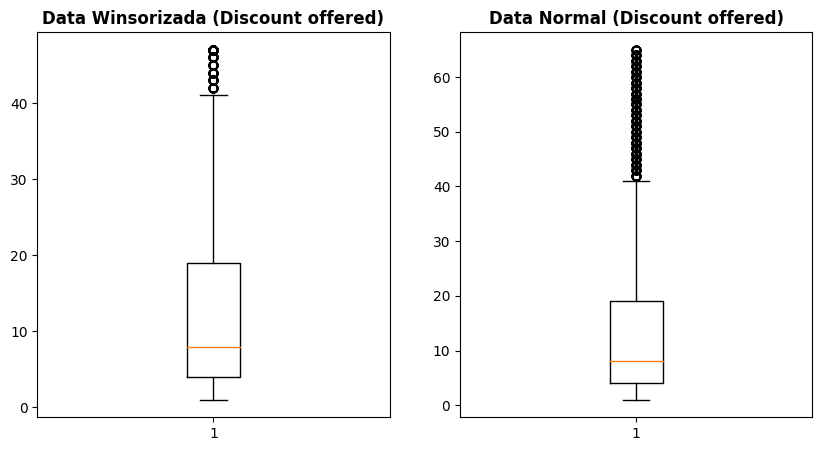

In [11]:
from scipy.stats.mstats import winsorize

winsorized= winsorize(df_train["Discount_offered"],(0,0.10))

#Visualization
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(winsorized)
plt.title("Data Winsorizada (Discount offered)",fontsize=12,fontweight="bold")
plt.subplot(1,2,2)
plt.boxplot(df_train["Discount_offered"].values)
plt.title("Data Normal (Discount offered)",fontsize=12,fontweight="bold")
plt.show()

    Observacion: 
* Mediante la aplicacion de la **Winsorizacion** se puede visualizar la disminucion de outliers, donde se tomo el 10% de los valores extremos para su correccion.

In [12]:
# Se reemplaza la variable winzorizada a nuestro
df_train["Discount_offered"] = winsorized
df_train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,47,3088,1
2,3,A,Flight,2,2,183,4,low,M,47,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


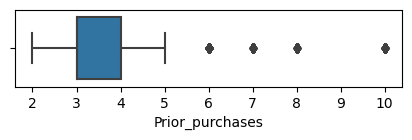

Cantidad de registros totales: 8999
Cantidad de outliers = 798
Porcentaje de outliers = 8.867651961329038


In [13]:
Variable='Prior_purchases'
data=df_train_cuant

Q1 = data[Variable].quantile(0.25)
Q3 = data[Variable].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

plt.figure(figsize = (5,1))
sns.boxplot(x = 'Prior_purchases', data = df_train)
plt.show()

print('Cantidad de registros totales:', data.shape[0])
print('Cantidad de outliers =', data[(data[Variable]<BI) | (data[Variable]>BS)].shape[0] )
print('Porcentaje de outliers =', (data[(data[Variable]<BI) | (data[Variable]>BS)].shape[0]/data.shape[0]*100) )

    Observaciones
* La presencia de outliers es menor al 10% de los datos.

### **Analizando variables cuantitativas**

In [14]:
df_train_cat = df_train[['Customer_rating','Product_importance','Warehouse_block','Mode_of_Shipment','Gender']]

Analisis EDA de las variables vategoricas

In [15]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (12, filas * 5))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

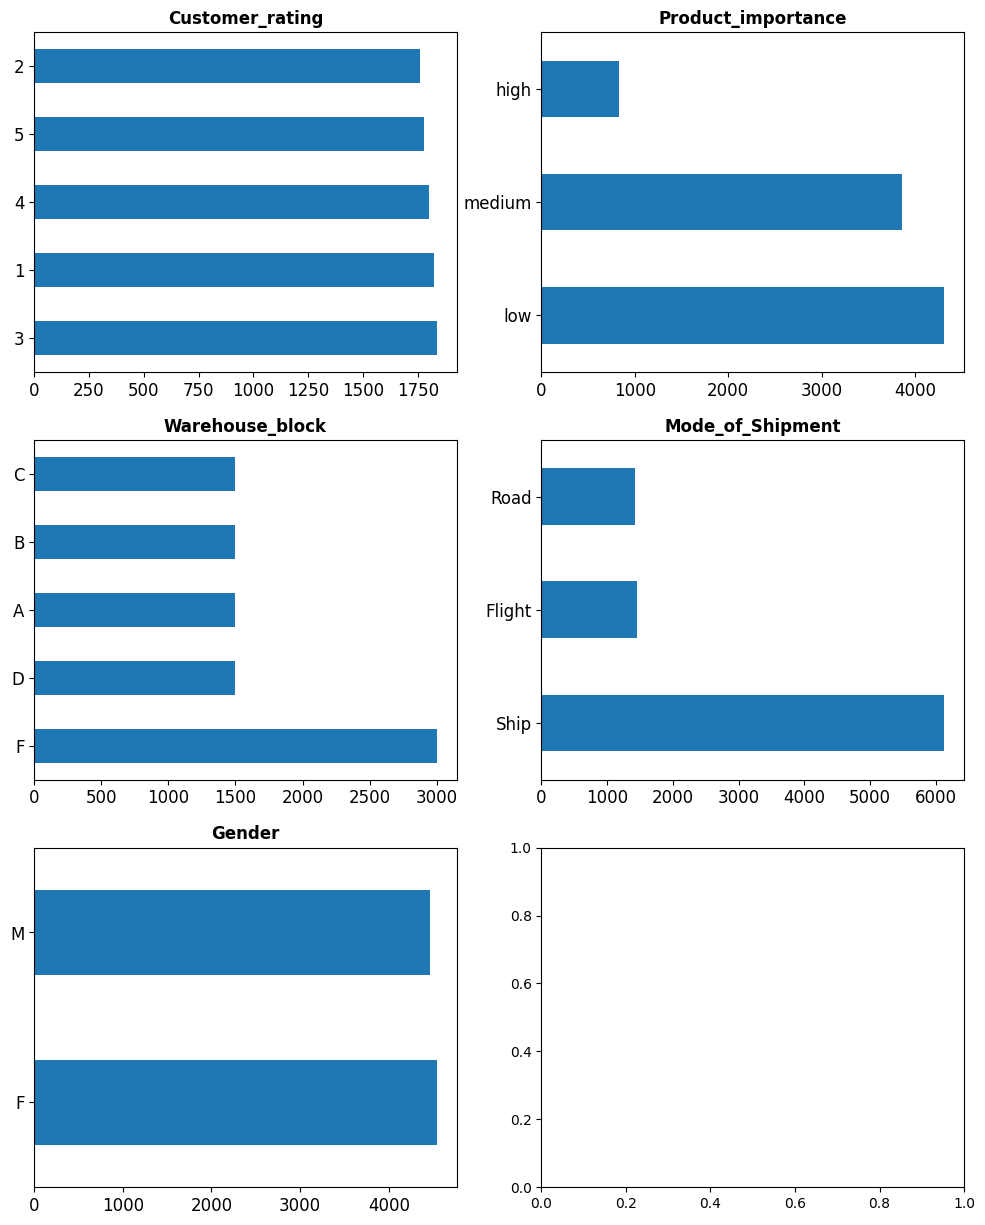

In [16]:
graficos_eda_categoricos(df_train_cat)

    Observaciones:

* Warehouse_block       : El **almacen F** tiene la mayor distribución de las ordenes.
* Mode_of_Shipment      : El modo de entrega mas frecuente es por **Embarcación**.
* Reached.on.Time_Y.N   : **El producto no llega a tiempo aproximadamente el 50% de los envios**.
* Product_importance    : Mayor presencia de productos de **Baja y Mediana importancia**.
* Customer_rating       : La puntuacion del cliente no muestra diferenciación.
* Gender                : El genero del comprador(a) es muy similar - entre hombres y mujeres.

### **Encoders**

In [17]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

**Enconder de variable ordinal**


In [18]:
# Label encoding
df_train_ord = df_train[['Product_importance']]

ls = df_train_ord.columns.tolist() 
for i in ls:
    df_train[i] = le.fit_transform(df_train[i])

**Encoder de variables nominales**

In [19]:
# One hot encoding
df_train = pd.get_dummies(df_train, columns=['Warehouse_block','Mode_of_Shipment','Gender'])

In [20]:
df_train.drop(columns=["ID"],axis=1,inplace=True)

In [21]:
df_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,1,0
1,4,5,216,2,1,47,3088,1,0,0,0,0,1,1,0,0,0,1
2,2,2,183,4,1,47,3374,1,1,0,0,0,0,1,0,0,0,1
3,3,3,176,4,2,10,1177,1,0,1,0,0,0,1,0,0,0,1
4,2,2,184,3,2,46,2484,1,0,0,1,0,0,1,0,0,1,0


# Modelamiento

 PRUEBA 1

In [22]:
target   = df_train["Reached.on.Time_Y.N"]
features = df_train.drop(["Reached.on.Time_Y.N"],axis=1)

PRUEBA 2

In [513]:
# features = df_train[['Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases','Product_importance','Discount_offered','Weight_in_gms','Warehouse_block_F','Mode_of_Shipment_Ship']]

PRUEBA 3

In [541]:
# features = df_train[['Discount_offered','Weight_in_gms']]

PRUEBA 4

In [566]:
# features = df_train[['Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases','Discount_offered','Weight_in_gms','Product_importance']]

PRUEBA 5

In [597]:
# features = df_train[["Customer_care_calls","Cost_of_the_Product","Discount_offered","Weight_in_gms"]]

# **MODELAMIENTO**

#### **Busqueda de mejores Hiperparametros**

Aplicando un **RandomizedSearchCV** para hallar los mejores hiperparametros

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.33, random_state=42)

# Importa libreria RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Número de árboles en el bosque aleatorio 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] 
# Número de características a considerar en cada división 
max_features = ['auto', 'sqrt'] 
# Número máximo de niveles en el árbol 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] 
max_depth.append(None) 
# Número mínimo de muestras requeridas para dividir un nodo 
min_samples_split = [2, 5, 10] 
# Número mínimo de muestras requeridas en cada nodo hoja 
min_samples_leaf = [1, 2, 4] 

# Se crea el random grid
random_grid = { 'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# Usamos el random grid para buscar el mejor Hiperparametro
# Random search of parameters,se utiliza validacion cruzada de 3 pliegues 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Se entrena el random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [25]:
# Primeros mejores hiparametros
rf_random.best_params_

{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}

    Observaciones:

* La búsqueda aleatoria nos permitió reducir el rango de cada hiperparámetro.Ahora se utilizan estos mejores primeros parametros para seguir ajustando el modelo

Aplicamos un **Grid Search** con **Cross Validation**

In [26]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [7, 10,12],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,4,5,6],
}
# Instanciamos el modelo
rf = RandomForestRegressor(random_state=42)
# Instanciamos el grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# entrenamos grid search con los datos
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 5, 6]},
             verbose=2)

In [28]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}

    Observaciones:

* Se evaluaron todas las conbinaciones definidas y ahora se muestran los mejores hiperparametros para ser evaluados.

#### **Prediccion**

In [52]:
#Aplicacion del modelo Random Forest Clasification
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.33, random_state=42)

# Scaling the data
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)
X_test = ms.fit_transform(X_test)

# Aplicamos el RandomForestClassifier con nuestros mejores hiperparametros
rf= RandomForestClassifier(max_depth = 7,min_samples_leaf=3,min_samples_split=2,criterion="entropy",random_state=42)
# Entrenamos el modelo
rf=rf.fit(X_train,y_train)
# Predecimos
y_train_pred_rf=rf.predict(X_train)
y_test_pred_rf=rf.predict(X_test)

In [53]:
#Reporte
print('El acurracy de los datos de entrenamiento:', accuracy_score(y_train,y_train_pred_rf))
print('El acurracy de los datos de testeo:', accuracy_score(y_test,y_test_pred_rf))
print ('Recall de los datos de entrenamiento:',recall_score(y_train,y_train_pred_rf))
print ('Recall de los datos de testeo :',recall_score(y_test,y_test_pred_rf))

El acurracy de los datos de entrenamiento: 0.7545198208658153
El acurracy de los datos de testeo: 0.7053872053872053
Recall de los datos de entrenamiento: 0.6694692590646348
Recall de los datos de testeo : 0.6529012023000522


---------------

# **CARGA DEL DATA SET - TEST.CVS**

In [38]:
df_test= pd.read_excel('./Datathon-main/E-Commerce_test.xlsx')

In [39]:
# Encoder 
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

# **Enconder de variable ordinal**
df_test_ord = df_test[['Product_importance']]
ls = df_test_ord.columns.tolist() 
for i in ls:
    df_test[i] = le.fit_transform(df_test[i])

# **Encoder de variables nominales**
df_test = pd.get_dummies(df_test, columns=['Warehouse_block','Mode_of_Shipment','Gender'])
df_test.drop(columns=["ID"],axis=1,inplace=True)
df_test.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,5,1,189,2,2,10,5248,0,0,0,0,1,0,0,1,0,1
1,5,3,150,2,0,9,4446,0,0,0,1,0,0,0,1,1,0
2,3,3,200,3,1,3,5739,0,0,0,0,1,0,0,1,0,1
3,5,1,133,2,2,1,4643,1,0,0,0,0,0,0,1,0,1
4,4,2,260,3,1,4,5504,0,1,0,0,0,0,0,1,0,1


### **Prediccion con nuevos datos**

In [41]:
y_predicho=rf.predict(df_test)
y_predicho

c:\Users\yoe_1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

----------------------
_________

> Descarga de prediccion: 

In [42]:
prediccion = pd.DataFrame( y_predicho, columns = ['pred'])

In [45]:
prediccion.to_csv('Yoelcaro14.csv',index=False)

----
---